# **Question 1**

In [4]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
np.set_printoptions(suppress=True)

In [42]:
X = genfromtxt('A2Q1.csv', delimiter=',')

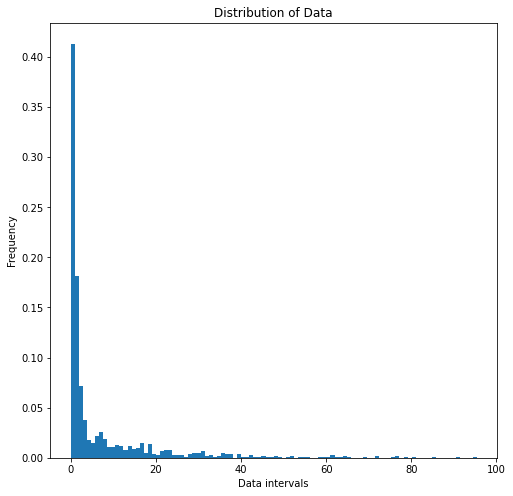

In [43]:
plt.figure(figsize=(8,8))
plt.hist(X,100,density=True)
plt.title("Distribution of Data")
plt.ylabel("Frequency")
plt.xlabel("Data intervals")
plt.show()

### **Question 1 (iii)**

In [44]:
def run_Kmeans(X,K,mu_i=None,max_iter=1000):
    #Parameters: Data, Number of Clusters, Initialised Means (Optional), maximum number of iterations (optional)
    #Returns the initialised means used,Final Means and Assignment Vector 
    n = X.shape[1]
    Z = np.zeros(n,dtype=np.uint8)
    error_history = []
    tolerance = 1

    #get k mu's, initialisation step
    if mu_i is None:
        mu_i = X[:,np.random.randint(0,X.shape[1],K)] #if no initial mu is passed, it is randomly chosen
    else:
        pass

    mu = mu_i.copy()

    for iter in range(max_iter):

        #finding error
        error=0
        for i in range(n):
            error_term = ((X[:,i]-mu[:,Z[i]])**2).sum()
            error += error_term

        error_history.append(error)

        # reassignment step
        for i in range(n):
            xi = X[:,i:i+1]
            Z[i] = np.argmin(((xi-mu)**2).sum(axis=0))

        # Finding Means
        k=0
        for k in range(K):
            if (Z==k).sum()!=0:
                mu[:,k] = (X*((Z==k).reshape(1,1000))).sum(axis=1)/(Z==k).sum()


        if iter>2:
            if abs(error_history[-1]-error_history[-2])<tolerance:
                #print("Number of Iterations Taken to Converge Llyods:",iter)
                break
    else:
        print("Not Converged. Maximum Number of Iteration Reached!")

    return mu_i,mu,Z,error_history

In [45]:
X_kmeans = X.reshape(1,1000); #shape of X_kmeans = (d,n)
mu_i,mu,Z,error_h = run_Kmeans(X_kmeans,4)

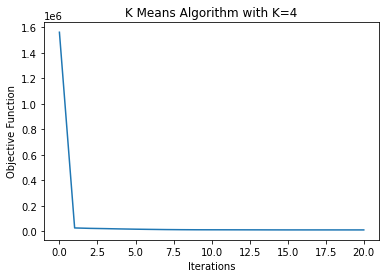

In [46]:
plt.plot(error_h)
plt.ylabel("Objective Function")
plt.xlabel("Iterations")
plt.title("K Means Algorithm with K=4")
plt.show()

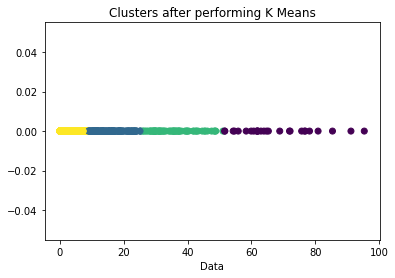

In [47]:
plt.scatter(X,np.zeros(1000),c=Z)
plt.xlabel("Data")
plt.title("Clusters after performing K Means")
plt.show()

### **Question 1 (i) and (ii)**

In [48]:
def exp_dist(x,pdf_params_k):
    mu = pdf_params_k[0]
    return (1/mu)*np.exp(-x/mu)

def gaussian_dist(x,pdf_params_k):
    mu = pdf_params_k[0]
    sigma = pdf_params_k[1]
    return (1/np.sqrt((2*np.pi*sigma*sigma)))*np.exp(-(x-mu)**2/(2*sigma*sigma))

def get_theta0(X,K,N,dist_func="Exponential"):

    if dist_func=="Exponential":
        max_x = X.max()
        pi = np.random.uniform(size=(K))
        pi = pi/pi.sum()

        mu = np.random.uniform(low=1,high=max_x,size=(1,K)) #choosing means in the range of the dataset and it cannot be zero for exponential distribution

        theta = {"pi":pi,"pdf_params":mu}

    elif dist_func=="Gaussian":

        #Running Llyods algorithm to initialise the value of theta
        X_kmeans = X.reshape(1,N); #shape of X_kmeans = (d,n)
        mu_i,mu,Z,error_h = run_Kmeans(X_kmeans,K)

        mu = mu.squeeze()
        sigma = np.zeros(K)
        pi = np.zeros(K)

        for k in range(K):
            assignment_vec = (Z==k)
            sigma[k] = np.sqrt(((((X-mu[k])**2)*assignment_vec).sum())/(assignment_vec).sum())
            pi[k] = assignment_vec.sum()/N

        theta = {"pi":pi,"pdf_params":np.vstack([mu,sigma])}

    return theta

def get_argmax_lambda(theta,X,K,N,dist_func="Exponential"):
    '''Parameters: 
       theta = parameters_dictionary, X = data, K=number of components, N=Number of Datapoints, dist_func=component distribution function(exponential or gaussian)
       Returns: Lamda matrix of shape (N,K)'''

    if dist_func == "Exponential":
        func = exp_dist
    elif dist_func == "Gaussian":
        func = gaussian_dist
        
    pi = theta["pi"]
    pdf_params = theta["pdf_params"] 
    Lambda = np.zeros((N,K))
    for i in range(N):
        for k in range(K):
            Lambda[i,k] = func(X[i],pdf_params[:,k])*pi[k]
        
        Lambda[i,:] = Lambda[i,:]/(Lambda[i,:].sum())
        
    return Lambda

def get_argmax_theta(Lambda,X,K,N,dist_func="Exponential"):
    if dist_func == "Exponential":
        mu = (Lambda*X.reshape(-1,1)).sum(axis=0)/(Lambda.sum(axis=0))
        pi = (Lambda.sum(axis=0))/N
        theta = {"pi":pi,"pdf_params":mu.reshape(1,-1)}

    elif dist_func == "Gaussian":
        mu = (Lambda*X.reshape(-1,1)).sum(axis=0)/(Lambda.sum(axis=0))
        pi = (Lambda.sum(axis=0))/N
        sigma = np.sqrt((Lambda*((X.reshape(-1,1)-mu.reshape(1,-1))**2)).sum(axis=0)/Lambda.sum(axis=0)) 

        theta = {"pi":pi,"pdf_params":np.vstack([mu,sigma])}    
    return theta

def get_logL(theta,X,K,N,dist_func="Exponential"):
    if dist_func == "Exponential":
        func = exp_dist
    else:
        func = gaussian_dist

    pi = theta["pi"]
    pdf_params = theta["pdf_params"] 
    logL = 0
    for i in range(N):
        p_xi = 0
        for k in range(K):
            p_xi += pi[k]*(func(X[i],pdf_params[:,k]).item())
        
        logL += np.log(p_xi)

    return logL

def run_EM_algorithm(X,K,dist_func,max_iter=100,E=0.01):

    N = len(X)
    logL_history = []

    #Initialisation of Theta
    theta = get_theta0(X,K,N,dist_func) 

    for i in range(max_iter):
        #Storing the log-likelihood value at iteration i
        logL = get_logL(theta,X,K,N,dist_func)
        logL_history.append(logL)
        #E-step
        Lambda = get_argmax_lambda(theta,X,K,N,dist_func)
        
        #M-step
        theta = get_argmax_theta(Lambda,X,K,N,dist_func)

        #if the log-likelihood is not changing a lot or maximum number of iterations are reached, the loop is terminated
        if len(logL_history)>2 and logL_history[-1]-logL_history[-2]<E:
            break

    return theta,Lambda,logL_history

def fX(x,theta,dist_func):
    if dist_func == "Gaussian":
        func = gaussian_dist
    elif dist_func == "Exponential":
        func = exp_dist

    pi = theta["pi"]
    pdf_params = theta["pdf_params"]
    f_components = []
    f_val=0
    for k in range(K):
        f_component = pi[k]*func(x,pdf_params[:,k])
        f_val += f_component
        f_components.append(f_component)

    return f_val,f_components

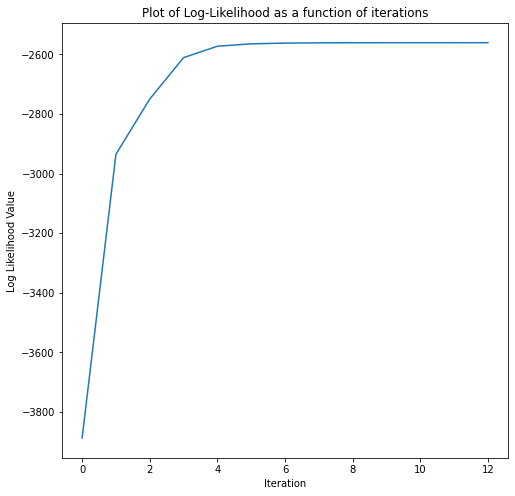

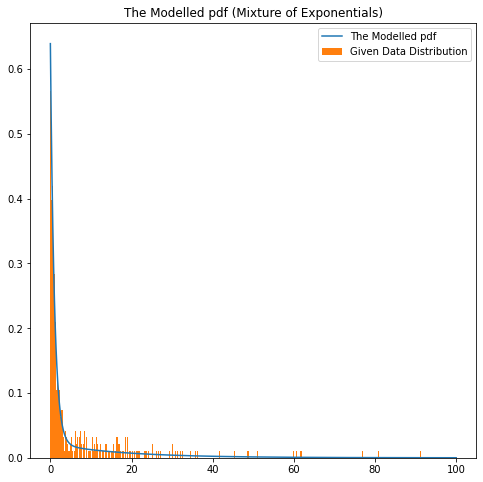

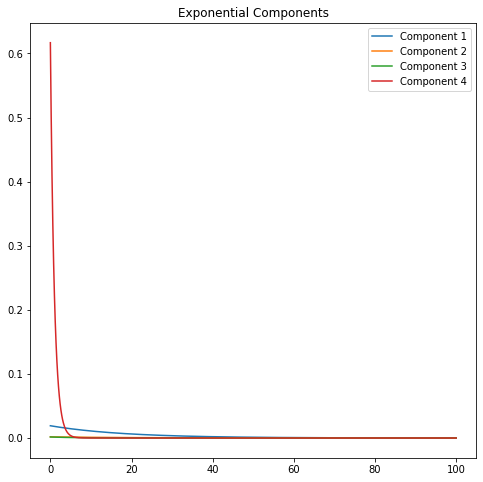

In [49]:
K = 4
dist_func = "Exponential"
theta, Lambda, logL_history = run_EM_algorithm(X,K,dist_func)

plt.figure(figsize=(8,8))
plt.plot(logL_history)
plt.title("Plot of Log-Likelihood as a function of iterations")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood Value")
plt.show()
x_vec = np.linspace(0,100,1000)
f_val,fX_exp_comps = fX(x_vec,theta,dist_func)

plt.figure(figsize=(8,8))
plt.plot(x_vec,f_val)
plt.title("The Modelled pdf (Mixture of {}s)".format(dist_func))
plt.hist(X,1000,density=True)
plt.legend(["The Modelled pdf","Given Data Distribution"])
plt.show()

plt.figure(figsize=(8,8))
for k in range(K):
    plt.plot(x_vec,fX_exp_comps[k])
plt.title("{} Components".format(dist_func))
plt.legend(["Component {}".format(i) for i in range(1,K+1)])
plt.show()

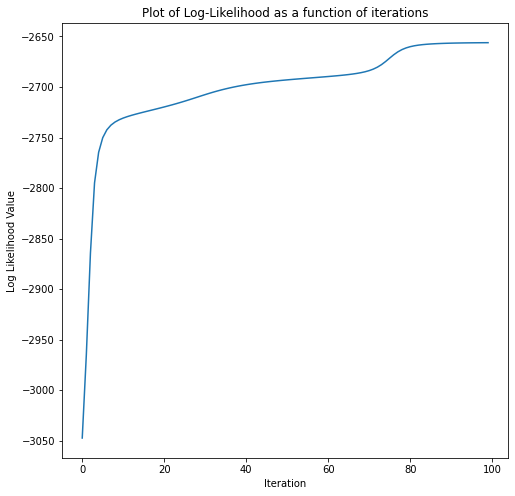

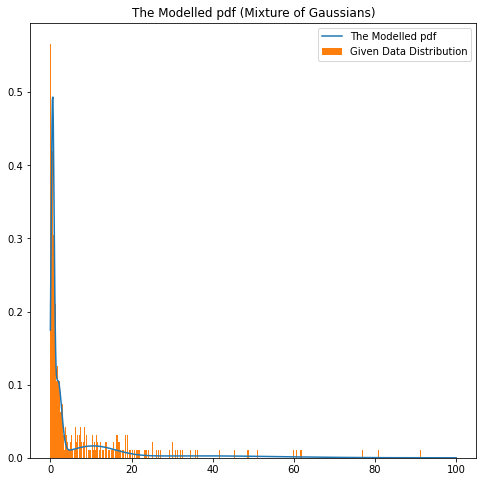

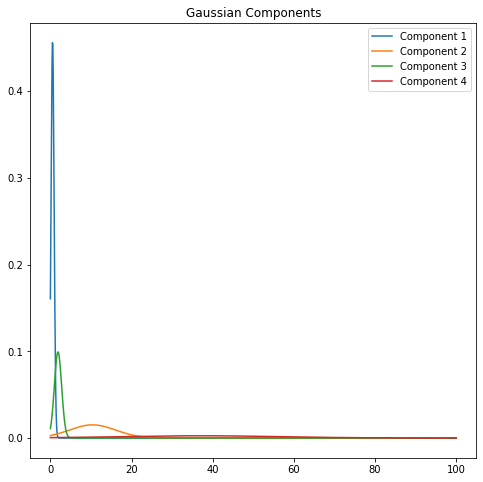

In [50]:
K = 4
dist_func = "Gaussian"
theta, Lambda, logL_history = run_EM_algorithm(X,K,dist_func)

plt.figure(figsize=(8,8))
plt.plot(logL_history)
plt.title("Plot of Log-Likelihood as a function of iterations")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood Value")
plt.show()
x_vec = np.linspace(0,100,1000)
f_val,fX_exp_comps = fX(x_vec,theta,dist_func)

plt.figure(figsize=(8,8))
plt.plot(x_vec,f_val)
plt.title("The Modelled pdf (Mixture of {}s)".format(dist_func))
plt.hist(X,1000,density=True)
plt.legend(["The Modelled pdf","Given Data Distribution"])
plt.show()

plt.figure(figsize=(8,8))
for k in range(K):
    plt.plot(x_vec,fX_exp_comps[k])
plt.title("{} Components".format(dist_func))
plt.legend(["Component {}".format(i) for i in range(1,K+1)])
plt.show()

# **Question 2**


In [7]:
def get_mse(y_true,y_pred):
    return ((y_true - y_pred)**2).sum()/len(y_true)

def analyse_model(w,X_train,X_test,y_train,y_test):
    y_pred_train = X_train.T@w
    y_pred_test = X_test.T@w

    print("Training set MSE: {:.5f}".format(get_mse(y_train,y_pred_train)))
    #print("Training set R2 Score: {:.5f}".format(r2_score(y_train,y_pred_train)))
    print("Test Set MSE: {:.5f}".format(get_mse(y_test,y_pred_test)))
    #print("Test Set R2 Score: {:.5f}".format(r2_score(y_test,y_pred_test)))

In [8]:
d=100
n=10000
data_train = genfromtxt('A2Q2Data_train.csv', delimiter=',')
data_test = genfromtxt("A2Q2Data_test.csv", delimiter=',')

In [9]:
X_train = data_train[:,:100].T #bringing X into the shape (d,n)
y_train = data_train[:,100:101]

In [10]:
X_test = data_test[:,:100].T
y_test = data_test[:,100:101]

### **Question 2 (i)**
Analytical Solution

In [11]:
w_ML = np.linalg.pinv(X_train@(X_train.T))@X_train@y_train

In [12]:
analyse_model(w_ML,X_train,X_test,y_train,y_test)

Training set MSE: 0.03969
Test Set MSE: 0.37073


### **Question 2 (ii)**
Using Gradient Descent

In [13]:
max_iter=1000
lr=0.01
E = 0.00001
Lambda = 0.1
w_GD = np.zeros((d,1))
mse_history = []
norm_difference_history = []
for i in range(max_iter):
    y_pred = (X_train.T)@w_GD
    dw = 2*X_train@(y_pred-y_train)/n 
    w_GD = w_GD - lr*dw
    mse = ((y_pred - y_train)**2).sum()/n
    mse_history.append(mse)

    norm_difference_history.append(np.linalg.norm(w_GD-w_ML))

    if len(mse_history)>2 and mse_history[-2]-mse_history[-1]<E:
        print("Number of Iterations Taken:",i)
        break

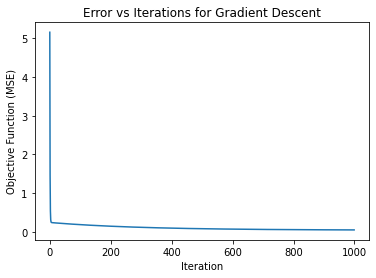

In [14]:
plt.plot(mse_history)
plt.xlabel("Iteration")
plt.ylabel("Objective Function (MSE)")
plt.title("Error vs Iterations for Gradient Descent")
plt.show()

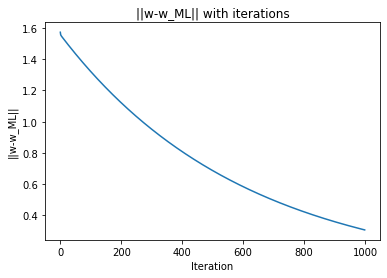

In [15]:
plt.plot(norm_difference_history)
plt.title("||w-w_ML|| with iterations")
plt.xlabel("Iteration")
plt.ylabel("||w-w_ML||")
plt.show()

In [16]:
analyse_model(w_GD,X_train,X_test,y_train,y_test)

Training set MSE: 0.04724
Test Set MSE: 0.31102


### **Question 2 (iii)**
Stochastic Gradient Descent

In [17]:
max_iter=1000
lr=0.01
batch_size = 100

w_sgd = np.zeros((d,1))
mse_history = []
norm_difference_history = []
w_vals = []
for i in range(max_iter):

    sampled_indices = np.random.randint(0,n,size=(batch_size))
    X_sampled = X_train[:,sampled_indices]
    y_sampled = y_train[sampled_indices]

    y_pred = (X_sampled.T)@w_sgd
    dw_sgd = 2*X_sampled@(y_pred-y_sampled)/batch_size
    w_sgd = w_sgd - lr*dw_sgd
    w_vals.append(w_sgd)

    mse = ((y_pred - y_sampled)**2).sum()/batch_size
    mse_history.append(mse)

    norm_difference_history.append(np.linalg.norm(w_sgd-w_ML))

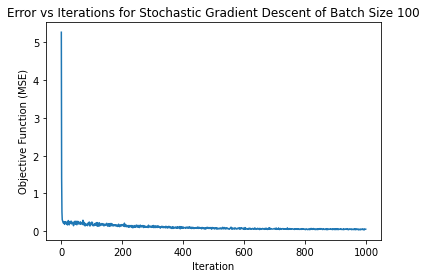

In [18]:
plt.plot(mse_history)
plt.xlabel("Iteration")
plt.ylabel("Objective Function (MSE)")
plt.title("Error vs Iterations for Stochastic Gradient Descent of Batch Size 100")
plt.show()

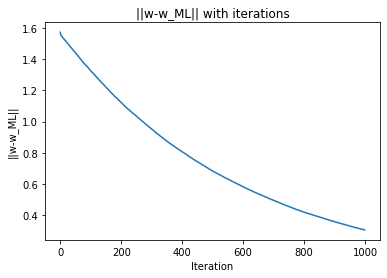

In [19]:
plt.plot(norm_difference_history)
plt.title("||w-w_ML|| with iterations")
plt.xlabel("Iteration")
plt.ylabel("||w-w_ML||")
plt.show()

In [20]:
analyse_model(w_sgd,X_train,X_test,y_train,y_test)

Training set MSE: 0.04802
Test Set MSE: 0.31238


### **Question 2 (iv)**
Ridge Regression

In [21]:
def run_ridge_regression(X_train,y_train,Lambda,w_ML,max_iter=2500,E=0.0001,lr=0.01):
    w = np.zeros((d,1))
    mse_history = []
    #r2_history = []
    obj_history = []
    norm_difference_history = []
    for i in range(max_iter):
        y_pred = (X_train.T)@w
        dw = (2*X_train@(y_pred-y_train) + 2*Lambda*w)/n
        w = w - lr*dw
        mse = ((y_pred - y_train)**2).sum()/n
        #r2 = r2_score(y_train,y_pred)
        #r2_history.append(r2)`
        obj_func = mse+ (Lambda*(w.T)@w).item()
        obj_history.append(obj_func)
        mse_history.append(mse)

        norm_difference_history.append(np.linalg.norm(w-w_ML))

        if i>10 and len(obj_history)>2 and (obj_history[-2]-obj_history[-1])<E:
            print("Number of Iterations:",i)
            break
    return w, mse_history,norm_difference_history,obj_history

In [22]:
K=5
X_train_splits = np.hsplit(X_train,K)
y_train_splits = np.vsplit(y_train,K)

In [23]:
def run_K_fold(X_train,y_train,Lambda,w_ML):
    mse_K_fold = []
    r2_K_fold = []
    for k in range(K):
        X_train_k = np.hstack(X_train_splits[0:k]+X_train_splits[k+1:])
        y_train_k = np.vstack(y_train_splits[0:k]+y_train_splits[k+1:])

        X_test_k = X_train_splits[k]
        y_test_k = y_train_splits[k]

        w,_,_,_ = run_ridge_regression(X_train_k,y_train_k,Lambda,w_ML)
        mse = get_mse(y_test_k,X_test_k.T@w)
        mse_K_fold.append(mse)

        r2 = r2_score(y_test_k,X_test_k.T@w)
        r2_K_fold.append(r2)

    mse_avg = sum(mse_K_fold)/len(mse_K_fold)
    r2_avg = sum(r2_K_fold)/len(r2_K_fold)
    return mse_avg, r2_avg

In [29]:
mse_lambda = []
for lamda in [0.05,0.1,0.5,1,5]:
    print("Lambda: ",lamda)
    mse,r2 = run_K_fold(X_train,y_train,lamda,w_ML)
    print("mse: ",mse,"r2:",r2)
    mse_lambda.append(mse)

Lambda:  0.05
Number of Iterations: 338
Number of Iterations: 340
Number of Iterations: 334
Number of Iterations: 335
Number of Iterations: 336
mse:  0.12275578084549625 r2: 0.522079810484432
Lambda:  0.1
Number of Iterations: 238
Number of Iterations: 240
Number of Iterations: 236
Number of Iterations: 237
Number of Iterations: 237
mse:  0.14709856415843364 r2: 0.4272679723086522
Lambda:  0.5
Number of Iterations: 69
Number of Iterations: 70
Number of Iterations: 68
Number of Iterations: 69
Number of Iterations: 69
mse:  0.20655592221673844 r2: 0.1956571274976481
Lambda:  1
Number of Iterations: 11
Number of Iterations: 11
Number of Iterations: 11
Number of Iterations: 11
Number of Iterations: 11
mse:  0.2340217863758683 r2: 0.08864030282712528
Lambda:  5
Number of Iterations: 11
Number of Iterations: 11
Number of Iterations: 11
Number of Iterations: 11
Number of Iterations: 11
mse:  0.23402247309280916 r2: 0.08863778265081987


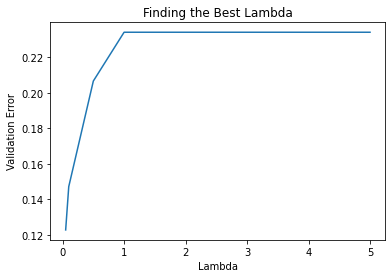

In [31]:
plt.plot([0.05,0.1,0.5,1,5],mse_lambda)
plt.xlabel("Lambda")
plt.ylabel("Validation Error")
plt.title("Finding the Best Lambda")
plt.show()

In [32]:
print("Analytical Solution wL")
analyse_model(w_ML,X_train,X_test,y_train,y_test)

Analytical Solution wL
Training set MSE: 0.03969
Test Set MSE: 0.37073


In [33]:
print("Ridge Regression wR")
wR,mse_his,_,obj_history = run_ridge_regression(X_train,y_train,0.05,w_ML)
analyse_model(wR,X_train,X_test,y_train,y_test)

Ridge Regression wR
Number of Iterations: 363
Training set MSE: 0.09977
Test Set MSE: 0.23833
